# Linear program

Linear program is inspired and described in this paper: Peter Kairouz, Sewoong Oh, and Pramod Viswanath. Extremal mechanisms for local differential privacy. The Journal of Machine Learning Research, 17(1):492–542, 2016.

For a discrete probability models with cardinality of the set of possible observations $|X| = k$ the formulation of the linear programe is

$$\begin{align*}
\text{maximize}_{\Theta \in \mathbb{R}^{2^k \times 2^k}} f(\Theta) &= \sum_{i=1}^{2^k} \mu(S_i^{(k)}) \Theta_{ii} \\
\text{subject to} \hspace{0.5cm}& S_i^{(k)} \Theta \mathbb{I} = \mathbb{I} \\
& \Theta \text{diagonal} \\
& \Theta \geq 0.
\end{align*}$$

where $\mu(s) = \frac{(\sum_{x\in X} Q(s|x) \dot{p}_\theta (x))^2}{\sum_{x\in X} Q(s|x) p_\theta (x)}$ is the "element-wise" Fisher-Information of the private data and $S^{(k)}$ is a staircase matirx of dimension $k\times 2^k$. The optimal algorithm is then represented as $Q = S^{(k)}\Theta$.

For the implementation of the algorithm we can re-formulate the linear program as a function of a vector $\beta$ which is defined as the diagonal elements of the matrix $\Theta$. In this case, we get

$$\begin{align*}
\text{maximize}_{\beta \in \mathbb{R}^{2^k}} f(\beta) &= \sum_{i=1}^{2^k} \mu(S_i^{(k)}) \beta_i \\
\text{subject to} \hspace{0.5cm} &S_i^{(k)} \beta = \mathbb{I} \\
& \beta \geq 0.
\end{align*}$$

In [1]:
from scipy.optimize import linprog
import numpy as np
import itertools
from typing import Tuple

def generate_staircase_matrix(k: int, epsilon: float) -> np.ndarray:
    """
    Generates the staircase matrix of size k x 2^k.
    E.g. for k = 2 we get
    1      1      e^epsilon      e^epsilon
    1  e^epsilon      1          e^epsilon

    Parameters
    ----------
    k : int
        problem dimension of the mapping
    epsilon : float
        privacy parameter

    Returns
    -------
    np.ndarray
        staircase matrix
    """
    elements = [1, np.exp(epsilon)]
    columns = list(itertools.product(elements, repeat=k))
    S = np.array(columns).T
    return S

def compute_mu(s: np.ndarray, p_theta: np.ndarray, p_theta_dot:np.ndarray) -> float:
    """
    Computes mu(S_i^(k)), that is the "weight" for our linear program.

    Parameters
    ----------
    s : np.ndarray
        a single column of the staircase matrix
    p_theta : np.ndarray
        vector of private probabilities
    p_theta_dot : np.ndarray
        derivative of the vector above with respect to theta

    Returns
    -------
    float
        weight
    """
    # s: Column vector from the staircase matrix S
    # p_theta: Probability distribution of the private data
    # p_theta_dot: Derivative of the probability distribution
    numerator = sum([s[i] * p_theta_dot[i] for i in range(len(s))])**2
    denominator = sum([s[i] * p_theta[i] for i in range(len(s))])
    return numerator / denominator

def solve_linear_program(S: np.ndarray, k: int, mu_values: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Given the staircase matrix S, k the cardinality of the private
    alphabet, and mu_values the precomputed weights this function
    calculates the optimal beta values that maximize the
    fisher information of the sanitized data.
    The output includes both the optimal theta values
    and the maximum value of the fisher information.

    Parameters
    ----------
    S : np.ndarray
        staircase matrix
    k : int
        alphabet dimension
    mu_values : np.ndarray
        precomputed weights

    Returns
    -------
    Tuple[np.ndarray, float]
        optimal beta values, max fisher
    """
    c = -mu_values  # Negate for maximization
    bounds = [(0, None) for _ in range(len(mu_values))]
    A_eq = S
    b_eq = np.ones(k)
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    if result.success:
        beta_opt = result.x
        max_value = -result.fun
        return beta_opt, max_value
    else:
        raise ValueError("Linear program did not converge")


# utiliti print functions
def print_matrix(matrix):
    for i, row in enumerate(matrix):
        print(f"row {i}: " + '\t'.join(map(str, row)))

def reduce_optimal_matrix(matrix):
    nonzero_rows = list()
    for i in range(matrix.shape[1]):
        if np.all(matrix[:,i]):
            nonzero_rows.append(matrix[:,i])
    return np.array(nonzero_rows).T


## Binomial with 2 tries

Let's say we know our data is generated by $Binom_\theta (k, n=2)$. The pmf is

$$ p_\theta (k;n) = {n\choose k} \theta^k (1-\theta)^{n-k}. $$

The derivative with respect to $\theta$ can be found to be

$$ \frac{\partial p_\theta}{\partial \theta} = {n\choose k} \left[ k\theta^{k-1}(1-\theta)^{n-k} - (n-k)(1-\theta)^{n-k-1} \theta^k \right].$$

For $n=2$, we can evaluate:

$$\begin{align*}
\frac{\partial p_\theta}{\partial \theta}(k=0) &= 2(\theta-1) \\
\frac{\partial p_\theta}{\partial \theta}(k=1) &= 2 - 4\theta \\
\frac{\partial p_\theta}{\partial \theta}(k=2) &= 2\theta
\end{align*}$$

In [2]:
from scipy.stats import binom
from scipy.special import comb

def binom_derivative(k, n, theta):
    if k > n:
        raise Exception("Can't have k > n")
    first = k*np.power(theta, k-1)*np.power(1-theta, n-k)
    second = (n-k)*np.power(1-theta, n-k-1)*np.power(theta, k)
    return comb(n, k) * (first - second)


def binom_optimal_privacy(n_trials: int, epsilon: float, theta: float) -> Tuple[np.ndarray, float]:
    """
    Parameters
    ----------
    n_trials : int
        number of trials in binomial
    epsilon : float
        privacy param
    theta : float
        succes probability

    Returns
    -------
    Tuple[np.ndarray, float]
        optimal Q matrix, max fisher information
    """
    # input space is n_trials since we can have at most n
    # successes
    k = n_trials + 1 # output space includes 0
    S = generate_staircase_matrix(k, epsilon)
    p_theta = binom.pmf(np.arange(k), n_trials, theta)
    p_theta_dot = np.zeros(p_theta.shape)
    for i in range(k):
        p_theta_dot[i] = binom_derivative(i, n_trials, theta)
    
    mus = compute_mu(S, p_theta, p_theta_dot)
    opt_theta, max_fisher = solve_linear_program(S, k, mus)
    Q_matrix = S @ np.diag(opt_theta)

    return Q_matrix, max_fisher

## $n=2, \epsilon=0.5$

We should observe two modes here, one for $\theta < 0.5$ and another one for $\theta > 0.5$.

In [3]:
n = 2
epsilon = 1
theta = 0.3

Q_matrix, max_fisher = binom_optimal_privacy(n, epsilon, theta)
Q_matrix_reduced = reduce_optimal_matrix(Q_matrix)

print("Optimal Q_matrix: ")
print_matrix(Q_matrix_reduced)
print("Maximum fisher value:", max_fisher)

theoretical_best_matrix = 1/(1+np.exp(epsilon)) * np.array([[1, np.exp(epsilon)], [np.exp(epsilon), 1], [np.exp(epsilon), 1]])
print("Theoretical best matrix")
print_matrix(theoretical_best_matrix)

Optimal Q_matrix: 
row 0: 0.26894142136999516	0.7310585786300048
row 1: 0.7310585786300049	0.2689414213699951
row 2: 0.7310585786300049	0.2689414213699951
Maximum fisher value: 1.6743928016986116
Theoretical best matrix
row 0: 0.2689414213699951	0.7310585786300048
row 1: 0.7310585786300048	0.2689414213699951
row 2: 0.7310585786300048	0.2689414213699951


In [4]:
theta = 0.7

Q_matrix, max_fisher = binom_optimal_privacy(n, epsilon, theta)
Q_matrix_reduced = reduce_optimal_matrix(Q_matrix)

print("Optimal Q_matrix: ")
print_matrix(Q_matrix_reduced)
print("Maximum fisher value:", max_fisher)

theoretical_best_matrix = 1/(1+np.exp(epsilon)) * np.array([[1, np.exp(epsilon)], [1, np.exp(epsilon)], [np.exp(epsilon), 1]])
print("Theoretical best matrix")
print_matrix(theoretical_best_matrix)

Optimal Q_matrix: 
row 0: 0.26894142136999516	0.7310585786300048
row 1: 0.26894142136999516	0.7310585786300048
row 2: 0.7310585786300049	0.2689414213699951
Maximum fisher value: 1.674392801698612
Theoretical best matrix
row 0: 0.2689414213699951	0.7310585786300048
row 1: 0.2689414213699951	0.7310585786300048
row 2: 0.7310585786300048	0.2689414213699951


The results look good, we observe two regimes.

## $\epsilon = 2$

Here, we should obtain a third regime for $\theta \in [\tau, 1-\tau]$ where $\tau \approx 0.4083$.

In [5]:
n = 2
epsilon = 2
theta = 0.5

Q_matrix, max_fisher = binom_optimal_privacy(n, epsilon, theta)
Q_matrix_reduced = reduce_optimal_matrix(Q_matrix)

print("Optimal Q_matrix: ")
print_matrix(Q_matrix_reduced)
print("Maximum fisher value:", max_fisher)

theoretical_best_matrix = 1/(2+np.exp(epsilon)) * np.array([[1, 1, np.exp(epsilon)], [1, np.exp(epsilon), 1], [np.exp(epsilon), 1, 1]])
print("Theoretical best matrix")
print_matrix(theoretical_best_matrix)

Optimal Q_matrix: 
row 0: 0.10650697891920075	0.10650697891920072	0.7869860421615985
row 1: 0.10650697891920075	0.7869860421615983	0.10650697891920075
row 2: 0.7869860421615985	0.10650697891920072	0.10650697891920075
Maximum fisher value: 3.3478451692264577
Theoretical best matrix
row 0: 0.10650697891920075	0.10650697891920075	0.7869860421615985
row 1: 0.10650697891920075	0.7869860421615985	0.10650697891920075
row 2: 0.7869860421615985	0.10650697891920075	0.10650697891920075


## $n=1$ and $n=2$ optimal fisher information

Fisher information of the binomial distribution is

$$I(\theta) = \frac{n}{\theta(1-\theta)}. $$

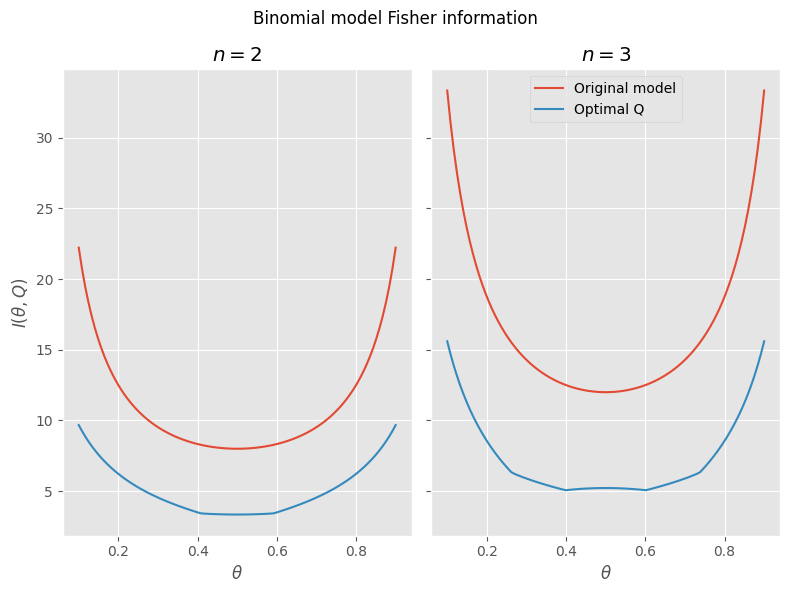

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

def fisher_information_privatized(Q: np.ndarray, p_theta: np.ndarray, p_theta_dot: np.ndarray) -> float:
    numerator = np.power(Q@p_theta_dot, 2)
    denominator = Q@p_theta
    return np.sum(numerator / denominator)

def fisher_information_original(n: int, theta:float) -> float:
    return n / (theta*(1-theta))

EPSILON = 2.0
thetas = np.linspace(1e-1, 1-1e-1, 100) # exclude boundaries

fig, ax = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)

# n=2
orig_fisher_infs = fisher_information_original(n=2, theta=thetas)
privatized_opt_fisher_infs = np.zeros(thetas.shape)
for i, theta in enumerate(thetas):
    opt_q_matrix, max_fisher = binom_optimal_privacy(n_trials=2, epsilon=EPSILON, theta=theta)
    privatized_opt_fisher_infs[i] = max_fisher

ax[0].plot(thetas, orig_fisher_infs, label="Original model")
ax[0].plot(thetas, privatized_opt_fisher_infs, label="Optimal Q")
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$I(\theta, Q)$")
ax[0].set_title("$n=2$")

# n = 3
orig_fisher_infs = fisher_information_original(n=3, theta=thetas)
privatized_opt_fisher_infs = np.zeros(thetas.shape)
for i, theta in enumerate(thetas):
    opt_q_matrix, max_fisher = binom_optimal_privacy(n_trials=3, epsilon=EPSILON, theta=theta)
    privatized_opt_fisher_infs[i] = max_fisher

ax[1].plot(thetas, orig_fisher_infs, label="Original model")
ax[1].plot(thetas, privatized_opt_fisher_infs, label="Optimal Q")
ax[1].set_xlabel(r"$\theta$")
ax[1].set_title("$n=3$")
ax[1].legend()

plt.suptitle("Binomial model Fisher information")
plt.tight_layout()
plt.show()

## Fisher information as a function of $\epsilon$

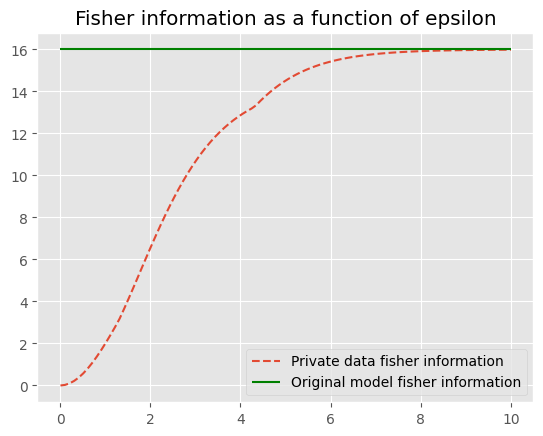

In [12]:
n = 4
theta = 0.5

orig_fisher = fisher_information_original(n, theta)

epsilons = np.linspace(1e-2, 10, 100)

fishers_private = list()
for eps in epsilons:
    q_matrix, fish = binom_optimal_privacy(n, eps, theta)
    fishers_private.append(fish)

fig, ax = plt.subplots()

ax.plot(epsilons, fishers_private, label="Private data fisher information", linestyle="--")
ax.hlines([orig_fisher], xmin=0, xmax=10, label="Original model fisher information", color="green")
plt.legend()
plt.title("Fisher information as a function of epsilon")
plt.show()